In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [5]:
# İşletim sistemi ve dosya yolları için
import os
import glob

# Veri analizi ve manipülasyonu için
import pandas as pd
import numpy as np

# Veri görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

# Görüntü işleme için
import cv2
from PIL import Image

# İlerleme çubukları için (isteğe bağlı, ama kullanışlı)
from tqdm import tqdm

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


In [6]:
# Ana veri yolu
BASE_DIR = '/kaggle/input/intel-image-classification/'

# Eğitim, test ve tahmin setlerinin yolları
train_dir = os.path.join(BASE_DIR, 'seg_train/seg_train')
test_dir = os.path.join(BASE_DIR, 'seg_test/seg_test')
pred_dir = os.path.join(BASE_DIR, 'seg_pred/seg_pred')

# Eğitim klasöründeki sınıfların (kategorilerin) isimlerini alalım
class_names = sorted(os.listdir(train_dir))

print("Toplam sınıf sayısı:", len(class_names))
print("Sınıf isimleri:", class_names)

Toplam sınıf sayısı: 6
Sınıf isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


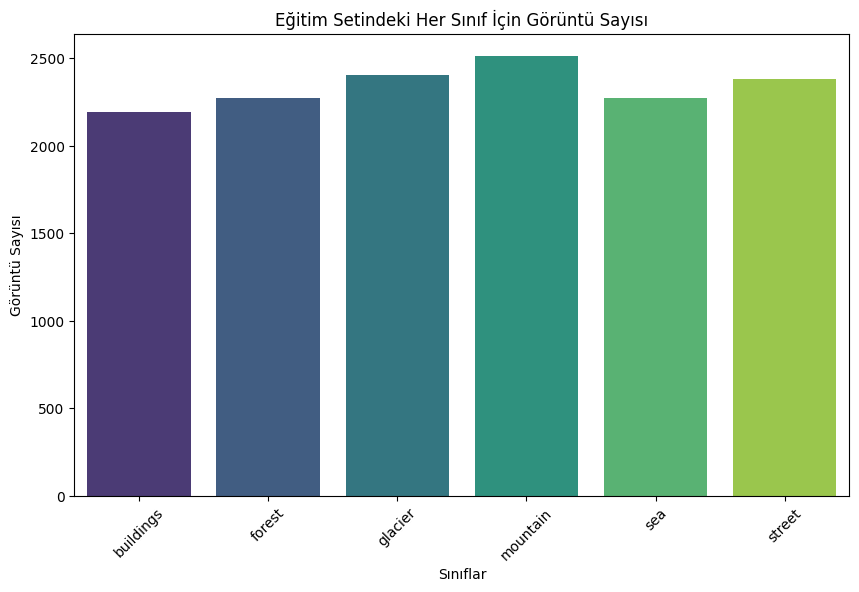

In [7]:
# Her sınıftaki görüntü sayılarını saklamak için bir sözlük oluşturalım
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    # Klasördeki dosya sayısını sayıyoruz
    count = len(os.listdir(class_path))
    image_counts[class_name] = count

# Görselleştirme için Pandas DataFrame'e dönüştürelim
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Sınıf', 'Görüntü Sayısı'])

# Grafiği çizelim
plt.figure(figsize=(10, 6))
sns.barplot(x='Sınıf', y='Görüntü Sayısı', data=df_counts, palette='viridis')
plt.title('Eğitim Setindeki Her Sınıf İçin Görüntü Sayısı')
plt.xlabel('Sınıflar')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45) # Sınıf isimlerinin daha iyi okunması için
plt.show()

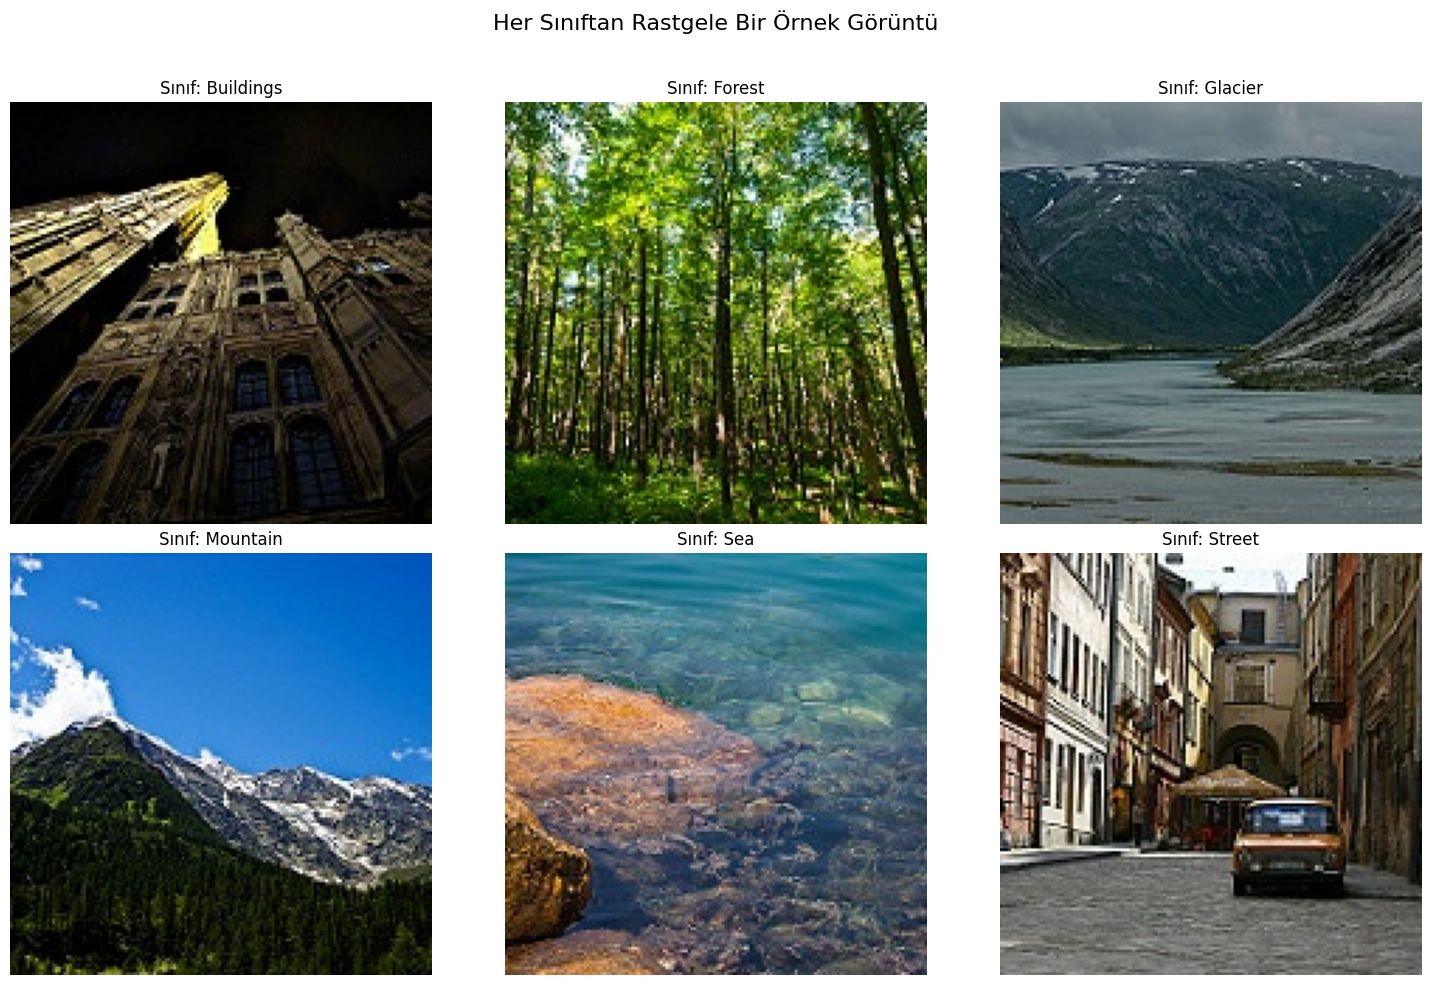

In [8]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    # Her sınıf klasörünün yolunu al
    class_path = os.path.join(train_dir, class_name)
    # Klasördeki tüm resimlerin listesini al
    image_files = os.listdir(class_path)
    # Rastgele bir resim seç
    random_image_path = os.path.join(class_path, np.random.choice(image_files))
    
    # Resmi oku
    image = Image.open(random_image_path)
    
    # 2x3'lük bir gridde i+1'inci alt grafiği oluştur
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Sınıf: {class_name.capitalize()}')
    plt.axis('off') # Eksenleri kapat

plt.suptitle('Her Sınıftan Rastgele Bir Örnek Görüntü', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Başlığın resimlerle çakışmasını engelle
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Görüntü boyutları ve batch size gibi hiperparametreleri tanımlayalım
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Eğitim verisi için veri çoğaltma ayarları ile bir generator oluşturma
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Piksel değerlerini 0-1 arasına ölçekle
    rotation_range=20,          # Görüntüleri rastgele 20 derece döndür [cite: 23]
    width_shift_range=0.2,      # Yatayda rastgele kaydır
    height_shift_range=0.2,     # Dikeyde rastgele kaydır
    shear_range=0.2,            # Görüntüyü yana doğru esnet
    zoom_range=0.2,             # Rastgele %20'ye kadar yakınlaştır [cite: 25]
    horizontal_flip=True,       # Görüntüleri rastgele yatayda çevir [cite: 24]
    fill_mode='nearest'         # Oluşan boş pikselleri en yakın komşuyla doldur
)

# Test/Validation verisi için sadece ölçekleme işlemi yapan bir generator oluşturma
# ÖNEMLİ: Doğrulama verisine augmentation uygulanmaz!
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Eğitim verilerini klasörden okuyacak üreteci oluşturma
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Tüm görüntüleri bu boyuta getir
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Çok sınıflı sınıflandırma olduğu için 'categorical' seçilir
)

# Test verilerini (doğrulama seti olarak kullanacağız) klasörden okuyacak üreteci oluşturma
validation_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Doğrulama setinde sıralamanın karışmaması önemlidir
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [12]:
# Sınıf isimleri ve atanan indeksler
class_indices = train_generator.class_indices
print("Sınıf İndeksleri:", class_indices)

# İndeksleri sınıflara çevirmek için bir ters harita oluşturalım
# Bu haritayı daha sonra tahminleri yorumlarken kullanabiliriz
inv_class_indices = {v: k for k, v in class_indices.items()}
print("İndeksten Sınıfa Harita:", inv_class_indices)

Sınıf İndeksleri: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
İndeksten Sınıfa Harita: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Modelimizi Sequential olarak tanımlıyoruz, yani katmanları sıralı bir şekilde ekleyeceğiz.
model = Sequential()

# 1. Evrişim ve Havuzlama Bloğu
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2. Evrişim ve Havuzlama Bloğu
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Evrişim ve Havuzlama Bloğu
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Sınıflandırma Katmanlarına Hazırlık
# Öznitelik haritalarını (feature maps) tek boyutlu bir vektöre düzleştiriyoruz.
model.add(Flatten())

# Tam Bağlantılı (Yoğun) Katman
# Dropout katmanı, overfitting'i önlemek için nöronların %50'sini rastgele devre dışı bırakır.
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Çıkış Katmanı
# 6 sınıfımız olduğu için 6 nöron ve çok sınıflı sınıflandırma için 'softmax' aktivasyonu kullanıyoruz.
model.add(Dense(6, activation='softmax'))

# Modelin özetini görüntüleyelim
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758884029.644532      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758884029.645224      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Modeli derliyoruz
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Çok sınıflı sınıflandırma için standart kayıp fonksiyonu
              metrics=['accuracy']) # Eğitim sırasında doğruluğu izlemek istiyoruz

In [23]:
# Modelin eğitimini başlatalım
# Bu işlem GPU'nuzun hızına bağlı olarak biraz zaman alabilir.
EPOCHS = 20 # Epoch sayısını daha sonra artırabiliriz

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Her epoch'ta kaç adım atılacağı
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE # Doğrulama için kaç adım atılacağı
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1758884041.083737     119 service.cc:148] XLA service 0x795848003e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758884041.084596     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884041.084619     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884041.414272     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/438 ━━━━━━━━━━━━━━━━━━━━ 50:13 7s/step - accuracy: 0.1250 - loss: 1.8198

I0000 00:00:1758884045.307820     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 309ms/step - accuracy: 0.4733 - loss: 1.3378 - val_accuracy: 0.6868 - val_loss: 0.8711
Epoch 2/20
  1/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6562 - loss: 0.8404

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6562 - loss: 0.8404 - val_accuracy: 0.7100 - val_loss: 0.8099
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.6486 - loss: 0.9177 - val_accuracy: 0.7520 - val_loss: 0.6855
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5938 - loss: 0.9634 - val_accuracy: 0.7369 - val_loss: 0.7124
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.7004 - loss: 0.8020 - val_accuracy: 0.7655 - val_loss: 0.6577
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7188 - loss: 0.7599 - val_accuracy: 0.7675 - val_loss: 0.6466
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.7368 - loss: 0.7020 - val_accuracy: 0.7571 - val_loss: 0.6703
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6562 - loss: 0.8556 - val_accuracy: 0.7947 - val_loss: 0.5657
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.7542 - loss: 0.6694 - val_accuracy: 0

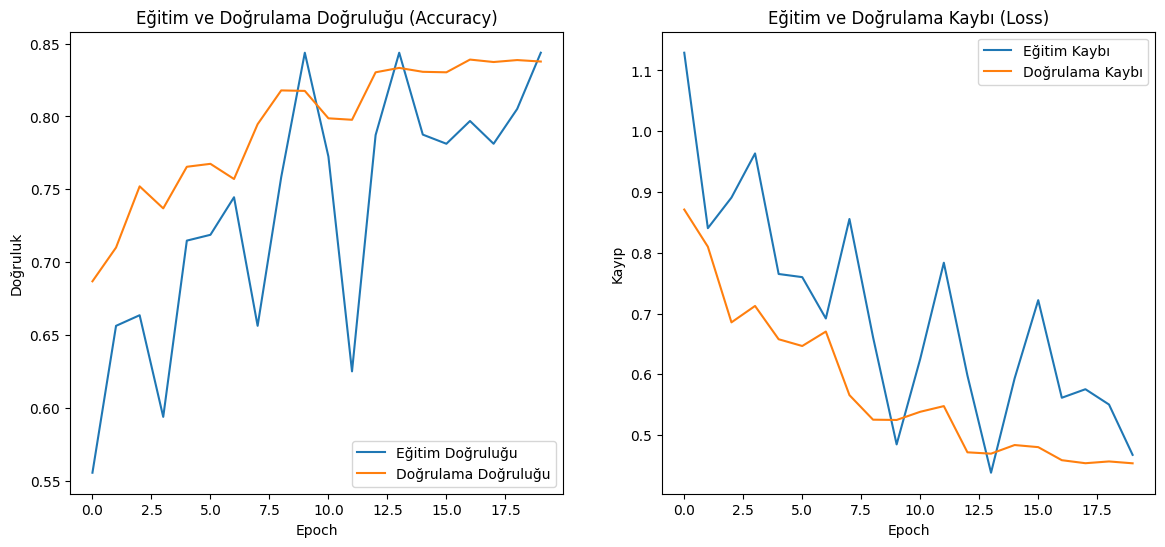

In [24]:
# Eğitim sonuçlarını görselleştirelim
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Sınıflandırma Raporu (Classification Report)
              precision    recall  f1-score   support

   buildings       0.78      0.89      0.83       437
      forest       0.94      0.98      0.96       474
     glacier       0.88      0.68      0.77       553
    mountain       0.74      0.83      0.78       525
         sea       0.82      0.84      0.83       510
      street       0.88      0.84      0.86       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



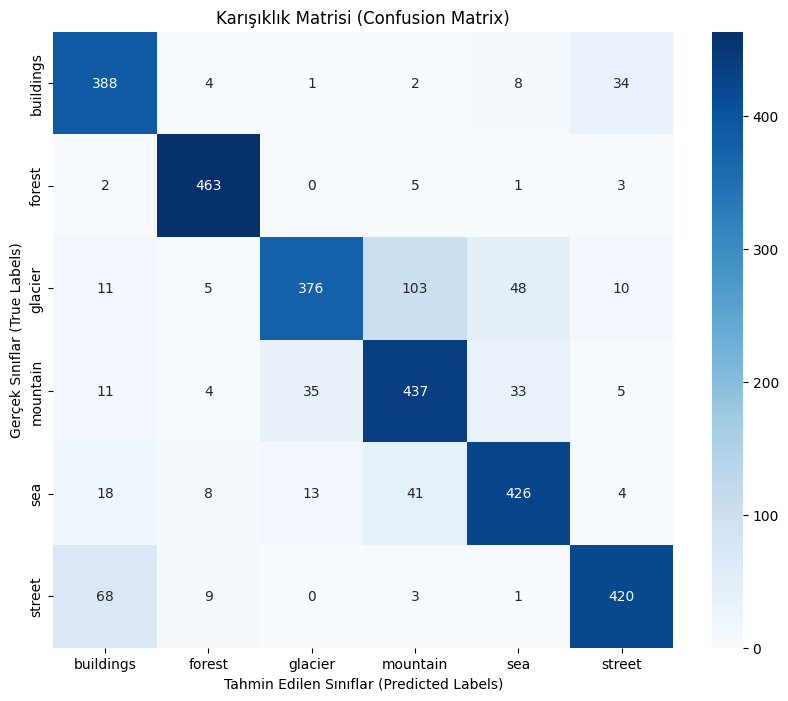

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Doğrulama verisi üzerinde tahmin yapma
# validation_generator'ı resetlememiz gerekebilir
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)

# Tahminleri sınıf etiketlerine dönüştürme (en yüksek olasılıklı sınıfı seçme)
y_pred = np.argmax(Y_pred, axis=1)

# Gerçek etiketleri alma
y_true = validation_generator.classes

# 1. Sınıflandırma Raporu
print('Sınıflandırma Raporu (Classification Report)')
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Karışıklık Matrisi (Confusion Matrix)
conf_matrix = confusion_matrix(y_true, y_pred)

# Matrisi daha okunabilir hale getirmek için Seaborn ile görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karışıklık Matrisi (Confusion Matrix)')
plt.ylabel('Gerçek Sınıflar (True Labels)')
plt.xlabel('Tahmin Edilen Sınıflar (Predicted Labels)')
plt.show()

In [26]:
from tensorflow.keras.applications import VGG16

# VGG16 modelini ImageNet ağırlıklarıyla ve kendi giriş şeklimizle yüklüyoruz.
# include_top=False -> Orijinal sınıflandırma katmanlarını dahil etme.
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Önceden eğitilmiş katmanların ağırlıklarının eğitim sırasında güncellenmesini engelliyoruz.
# Bu katmanlar "dondurulur".
conv_base.trainable = False

# Modelin temel yapısını görelim
conv_base.summary()

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Dropout

# VGG16 + kendi sınıflandırıcı katmanların (fonksiyonel model)
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = conv_base(inputs, training=False)  # VGG16 tabanı
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs, outputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)